In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer
import nbimporter
from task_vectors import TaskVector
from safetensors.torch import load_file
from transformers import pipeline
import numpy as np
import evaluate
import pandas as pd

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend

In [2]:
device, _, _ = get_backend() # automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
model_id = "./pretrained_gpt2"
finetuned_model_path = "./finetuned_gpt2_female_new"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)


In [3]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


In [4]:
import torch
from tqdm import tqdm
import numpy as np
from detoxify import Detoxify
import gc
from copy import deepcopy
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer and fix padding
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Required for some models

In [5]:
def normalize_weights(param_diff, eps=1e-6):
    norm = torch.norm(param_diff)
    return param_diff / (norm + eps)    
    
# Task Vector Class
class TaskVector:
    def __init__(self, pretrained_checkpoint, finetuned_checkpoint):
        # Keep models on CPU initially
        self.pretrained_model = AutoModelForCausalLM.from_pretrained(model_id).cpu()
        self.finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path).cpu()

    def __neg__(self):
        neg_vector = TaskVector.__new__(TaskVector)
        neg_vector.pretrained_model = self.pretrained_model
        neg_vector.finetuned_model = self.finetuned_model
        for p_pre, p_fine in zip(
            neg_vector.pretrained_model.parameters(), neg_vector.finetuned_model.parameters()
        ):
            p_fine.data = p_pre.data - p_fine.data
        return neg_vector

    def apply_to(self, base_model, scaling_coef):
        # Move only temporarily
        self.pretrained_model.to(device)
        self.finetuned_model.to(device)
        base_model = base_model.to(device)
    
        for p_base, p_pre, p_fine in zip(
            base_model.parameters(),
            self.pretrained_model.parameters(),
            self.finetuned_model.parameters(),
        ):
            p_base.data += scaling_coef * normalize_weights(p_fine.data - p_pre.data)

        # Clear memory here for better memory management
        self.pretrained_model.to("cpu")
        self.finetuned_model.to("cpu")
        torch.cuda.empty_cache()

        return base_model


In [6]:
# Initialize Task Vectors
task_vector = TaskVector(model_id, finetuned_model_path)

# Scaling coefficients
scaling_factors = np.arange(-1.0, 1.1, 0.1)

In [7]:
prompt = "You're a real"

In [8]:
import torch
from tqdm import tqdm

def calculate_perplexity(model, tokenizer, encodings, device):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)
    
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
    
            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    print(f"Perplexity: {ppl.item():.2f}")
    return ppl.item()


In [9]:
# Generation function
def generate_text(model, tokenizer, prompt, num_samples=5, max_new_tokens=100, device='cuda'):
    model.eval()
    model.to(device)
    samples = []

    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        inputs['pad_token_id'] = tokenizer.pad_token_id

        with torch.no_grad():
            output = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                pad_token_id=inputs['pad_token_id'],
                max_new_tokens=max_new_tokens,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
            )
        text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(text)

    return samples


In [10]:
"""calculate ppl replication (fast running)"""
from copy import deepcopy
import pandas as pd

# Load base model just once
base_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Store results
neg_to_pos_ppl_results = []

for scale in scaling_factors:
    print(f"\n--- Scaling factor: {scale:.1f} ---")

    # Clone base model and apply task vector scaling
    scaled_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
    task_vector.apply_to(scaled_model, scaling_coef=scale)

    # Calculate perplexity on Wikitext test set
    ppl = calculate_perplexity(scaled_model, tokenizer, encodings, device)

    # Store results for each scaling factor
    neg_to_pos_ppl_results.append((scale, ppl))

# Convert results to a DataFrame and save
ppl_df = pd.DataFrame(neg_to_pos_ppl_results, columns=['scaling_factor', 'ppl'])
ppl_df.to_csv("wikitext_ppl_results_female.csv", index=False)

print("Results saved to wikitext_ppl_results.csv")



--- Scaling factor: -1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [03:38<00:00,  2.57it/s]


Perplexity: 39.20

--- Scaling factor: -0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 36.23

--- Scaling factor: -0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:11<00:01,  1.51it/s]


Perplexity: 33.81

--- Scaling factor: -0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 31.83

--- Scaling factor: -0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 30.21

--- Scaling factor: -0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 28.86

--- Scaling factor: -0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 27.74

--- Scaling factor: -0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 26.82

--- Scaling factor: -0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 26.09

--- Scaling factor: -0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 25.54

--- Scaling factor: -0.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 25.17

--- Scaling factor: 0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 24.98

--- Scaling factor: 0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 24.98

--- Scaling factor: 0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 25.15

--- Scaling factor: 0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 25.49

--- Scaling factor: 0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 25.98

--- Scaling factor: 0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 26.63

--- Scaling factor: 0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 27.42

--- Scaling factor: 0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.51it/s]


Perplexity: 28.38

--- Scaling factor: 0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:11<00:01,  1.51it/s]


Perplexity: 29.54

--- Scaling factor: 1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]

Perplexity: 31.00
Results saved to wikitext_ppl_results.csv


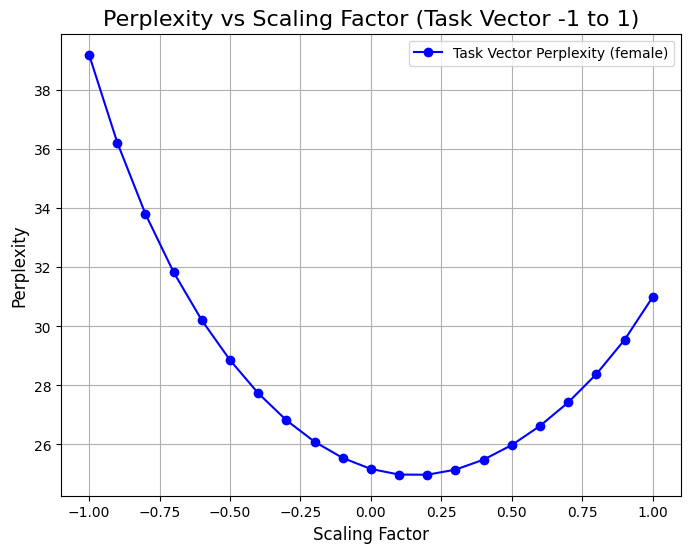

In [1]:
"""visaulize ppl"""
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved CSV file into a DataFrame
ppl_df = pd.read_csv("wikitext_ppl_results_female.csv")

# Filter for scaling_factor >= -0.5
#filtered_df = ppl_df[ppl_df['scaling_factor'] >= -0.5]
filtered_df = ppl_df[(ppl_df["scaling_factor"]>= -1.0) & (ppl_df["scaling_factor"] <= 1.0)]

# Assuming the DataFrame has columns named 'scale' and 'perplexity'
scaling_factors_pos = ppl_df['scaling_factor'] #<---- needs to change to ppl_df to remove filter
perplexities_pos = ppl_df['ppl'] #<---- needs to change to ppl_df to remove filter

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(scaling_factors_pos, perplexities_pos, marker='o', color='b', label="Task Vector Perplexity (female)")
plt.title("Perplexity vs Scaling Factor (Task Vector -1 to 1)", fontsize=16)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig("female_ppl_plot_full_scale.png", dpi=300)

plt.show()

In [14]:
import pandas as pd

# Load the CSV file
file_path = "wikitext_ppl_results_female.csv"
df = pd.read_csv(file_path)

# Round the 'scaling_factor' to the nearest one-decimal place and the ppl to 2 decimal places
df['scaling_factor'] = df['scaling_factor'].round(1)
df['ppl'] = df['ppl'].round(2)

# Sort the dataframe based on 'scaling_factor' from -1.0 to 1.0
df = df.sort_values(by='scaling_factor', ascending=True)

# Save the modified CSV to a new file
output_file_path = "female_wikitext_ppl_results_sorted.csv"
df.to_csv(output_file_path, index=False)

print(f"File saved as {output_file_path}")


File saved as female_wikitext_ppl_results_sorted.csv


In [15]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("female_wikitext_ppl_results_sorted.csv")

# Print the scores (scaling_factor and perplexity values)
print("Scaling Factor | Perplexity (PPL)")
print("----------------|----------------")

# Loop through the DataFrame and print the scaling factor and perplexity
for index, row in df.iterrows():
    print(f"{row['scaling_factor']}           | {row['ppl']}")

Scaling Factor | Perplexity (PPL)
----------------|----------------
-1.0           | 39.2
-0.9           | 36.23
-0.8           | 33.81
-0.7           | 31.83
-0.6           | 30.21
-0.5           | 28.86
-0.4           | 27.74
-0.3           | 26.82
-0.2           | 26.09
-0.1           | 25.54
-0.0           | 25.17
0.1           | 24.98
0.2           | 24.98
0.3           | 25.15
0.4           | 25.49
0.5           | 25.98
0.6           | 26.63
0.7           | 27.42
0.8           | 28.38
0.9           | 29.54
1.0           | 31.0


In [3]:
pwd

'C:\\Users\\Anneth\\Documents\\GitHub\\Thesis-2025\\extend_experiment'

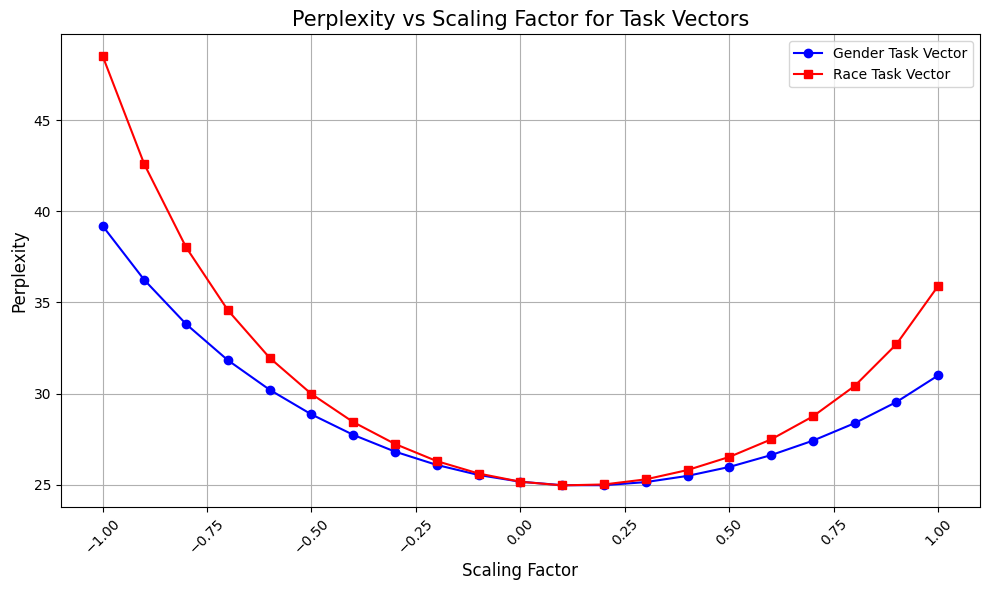

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Load both CSV files
df_female = pd.read_csv("female_wikitext_ppl_results_sorted.csv")
df_black = pd.read_csv("black_wikitext_ppl_results_sorted.csv")

# Optional: filter scaling factors between -1 and 1 for consistency
df_female = df_female[(df_female["scaling_factor"] >= -1.0) & (df_female["scaling_factor"] <= 1.0)]
df_black = df_black[(df_black["scaling_factor"] >= -1.0) & (df_black["scaling_factor"] <= 1.0)]

# Create specific scaling factor values to use as x-ticks
specific_ticks = [-1.0, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1.0]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_female['scaling_factor'], df_female['ppl'], marker='o', label="Gender Task Vector", color='blue')
plt.plot(df_black['scaling_factor'], df_black['ppl'], marker='s', label="Race Task Vector", color='red')

# Formatting
plt.title("Perplexity vs Scaling Factor for Task Vectors", fontsize=15)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)
plt.grid(True)

# Set x-ticks to match the specific scaling factors
plt.xticks(specific_ticks, rotation=45)

# Add the legend
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Save the plot
plt.savefig("combined_ppl_plot_female_black.png", dpi=300)
plt.show()


Perplexity Scores for Female and Black Task Vectors:
    scaling_factor  ppl_female  ppl_black
0    -1.000000e+00   39.203381  48.517086
1    -9.000000e-01   36.228828  42.574341
2    -8.000000e-01   33.808796  38.018097
3    -7.000000e-01   31.834103  34.565720
4    -6.000000e-01   30.208086  31.963097
5    -5.000000e-01   28.858356  29.982403
6    -4.000000e-01   27.738111  28.443893
7    -3.000000e-01   26.821239  27.235294
8    -2.000000e-01   26.092644  26.301706
9    -1.000000e-01   25.542929  25.616753
10   -2.220446e-16   25.170399  25.170399
11    1.000000e-01   24.980482  24.970514
12    2.000000e-01   24.975128  25.019535
13    3.000000e-01   25.147276  25.302124
14    4.000000e-01   25.485779  25.805077
15    5.000000e-01   25.981432  26.528818
16    6.000000e-01   26.628147  27.492207
17    7.000000e-01   27.424719  28.746656
18    8.000000e-01   28.383331  30.419313
19    9.000000e-01   29.543692  32.708336
20    1.000000e+00   30.996201  35.906021


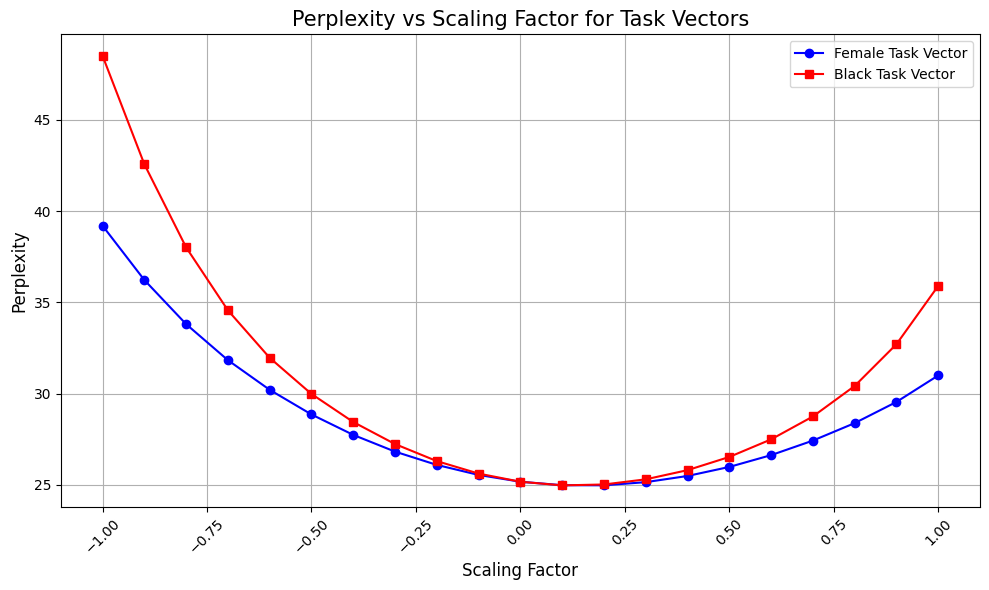

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load both CSV files
df_female = pd.read_csv("wikitext_ppl_results_female.csv")
df_black = pd.read_csv("wikitext_ppl_results_black.csv")

# Optional: filter scaling factors between -1 and 1 for consistency
df_female = df_female[(df_female["scaling_factor"] >= -1.0) & (df_female["scaling_factor"] <= 1.0)]
df_black = df_black[(df_black["scaling_factor"] >= -1.0) & (df_black["scaling_factor"] <= 1.0)]

# Merge the two dataframes on the 'scaling_factor' column
df_combined = pd.merge(df_female[['scaling_factor', 'ppl']], df_black[['scaling_factor', 'ppl']], 
                       on='scaling_factor', suffixes=('_female', '_black'))

# Print the table
print("Perplexity Scores for Female and Black Task Vectors:")
print(df_combined)

# Create specific scaling factor values to use as x-ticks
specific_ticks = [-1.0, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1.0]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_female['scaling_factor'], df_female['ppl'], marker='o', label="Female Task Vector", color='blue')
plt.plot(df_black['scaling_factor'], df_black['ppl'], marker='s', label="Black Task Vector", color='red')

# Formatting
plt.title("Perplexity vs Scaling Factor for Task Vectors", fontsize=15)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)
plt.grid(True)

# Set x-ticks to match the specific scaling factors
plt.xticks(specific_ticks, rotation=45)

# Add the legend
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Save the plot
plt.savefig("combined_ppl_plot_female_black.png", dpi=300)
plt.show()
